## 1) Import modules

In [8]:
using SudokuPlantDesign
using BenchmarkTools
using DataFrames
using Random
using XLSX
using PyPlot
using ColorTypes
using PyCall
@pyimport matplotlib.colors as matcolors

## 2) Define Trial sudoku data and define configuration

In [10]:
#define trialname
trialname="Testtrial_2021"
#define number of checktypes
numberofchecktypes=3
#define number of genotypes
numberofgenotypes=119
#define if only a design with checks should be generated (without genotypes): checks/all
designtype="all"
#define if entries shuffled (randomized) or not (sorted randomization for PM)
entries_randomized="yes"
#define name of list with entries and checks
templatename="Sample_data_Sudoku-augmented.xlsx"
#define color map
cmap_sudoku=ColorMap("Sudoku",
    [RGB(0.5,0.5,0.5),
        RGB(1, 0.933, 0.058),
        RGB(0.956, 0.164, 0.866),
        RGB(0.113, 0.666, 0.239),
        RGB(0.560, 0.368, 0.831),
        RGB(0.058, 0.733, 1),
        RGB(1,0,0),])
# define trial layout (x direction, y direction)
# we create here a design with 20 plots in x-direction and 10 plots in y-direction.

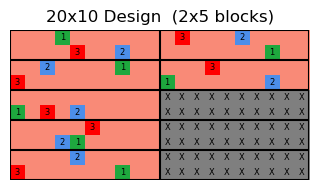

In [11]:
mkpath("output")
C = get_configuration([10,10], [2,2,2,2,2], numberofchecktypes)
initialize_checks_per_block!(C)
empty_plots!(C, 11:20,1:6) #optionally: define empty plots
show_configuration(C, zoom=0.2,cmap=cmap_sudoku)
savefig("output/initial_design_random_"*trialname*".pdf")

## 3) Define sudoku functions

### Define inverse temperature function

...

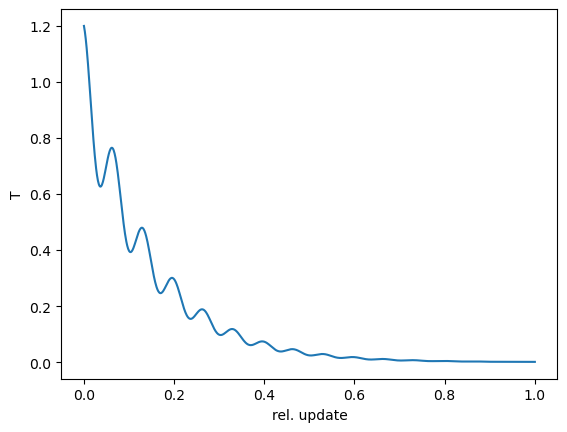

PyObject Text(24.000000000000007, 0.5, 'T')

In [12]:
beta(t) = 1*exp(-7*t) * (1 + 0.2*cos(t*30*pi))

plot(0:0.001:1, beta.(0:0.001:1))
xlabel("rel. update"); ylabel("T")

### Specify individual cost function for optimization

...

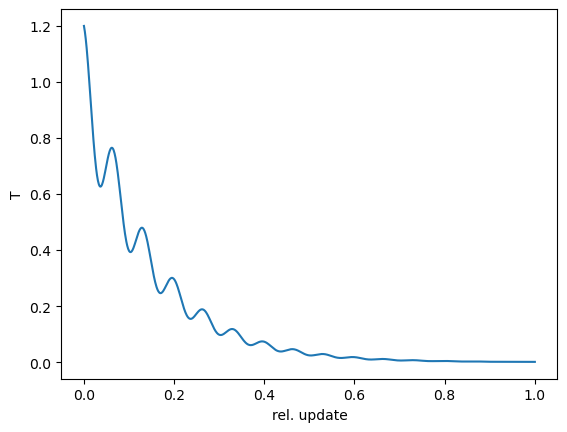

K_indiv (generic function with 1 method)

In [6]:
function K_indiv(conf :: C) :: Float64 where {C <: CheckConfiguration}
    return  K_num_checks_equal_per_type(conf) +
            K_checks_per_type_per_block(conf, 1)*20+
            K_neighbors_different_check_functional(conf, d->0.5/(d^3)) +
            K_neighbors_same_check_functional(conf, d->1/(d^3))*12
end

## 4) Run sudoku

In [10]:
kosten = optimize_design!(
    C,
    [UpdateNewCheckLabel(),UpdateSwapCheckCheck(),UpdateSwapCheckGenotype()],
    K_indiv,
    100000,
    beta
)


initialize_genotypes!(C, numberofgenotypes)
@showprogress "Optimizing Design ... " for i in 1:length(kosten)
    mc_update!(C, beta(i/length(kosten))*0.5, updates, K_indiv)
    kosten[i] = K_indiv(C)
end
kosten .-= minimum(kosten)
kosten .+= 1

#print things
println("Kosten: ",K_indiv(C)+kosten[1], " -> ", K_indiv(C)+kosten[end])
println("perc_checks: ",C.num_checks_total / (C.num_plots_total - C.num_checks_total))
println("genotypes: ",C.num_plots_total - C.num_checks_total)
println("checks:    ",C.num_checks_total, "  (", round(100*C.num_checks_total / C.num_plots_total, digits=2), "%)")
for i in 1:C.N
    println("check ($(i)): ",C.num_checks[i], "  (", round(100*C.num_checks[i] / C.num_checks_total, digits=2), "%)")    
end

show_configuration(C,cmap=cmap_sudoku,zoom=0.2)


figure()
plot(kosten)
yscale("log")


#save without check labels
show_configuration(C,check_labels=false,cmap=cmap_sudoku)
#savefig("final_sudoku_design_"*trialname*".png")
savefig("final_sudoku_design_"*trialname*".pdf")

## 6) Plot with Plant_Codes and write data to xlsx

UndefVarError: [91mUndefVarError: move not defined[39m

## 5) Save field plan and design data

In [ ]:
#read in check data
checkdata = DataFrame(XLSX.readtable(templatename, "checks")...)
checknames=names(checkdata)
for i in 1:length(checknames)
    checkdata[!,Symbol(checknames[i])]=string.(collect(checkdata[!,Symbol(checknames[i])]))
end
if nrow(checkdata)!= numberofchecktypes
    println("Number of checks in csv not matching pre-defined checks!")
end


#replace missing with NA
for col in eachcol(checkdata)
    replace!(col,missing => "NA")
end


#depending on reading in additionally genotype file
if  designtype=="checks"
    print("Only checks were successfully read in, as specified")
    
elseif designtype=="all"
    #read in genotype data
    genotypedata = DataFrame(XLSX.readtable(templatename, "entries")...)
    genonames=names(genotypedata)
    for i in 1:length(checknames)
        genotypedata[!,Symbol(genonames[i])]=string.(collect(genotypedata[!,Symbol(genonames[i])]))
    end
    #replace missing with NA
    for col in eachcol(genotypedata)
        replace!(col,missing => "NA")
    end
    
    #catch if not matching number of genotypes
    if nrow(genotypedata)!= numberofgenotypes
        println("Number of genotypes in xlsx datafile not matching pre-defined number of genotypes!")
    end
    
    
    #shuffle genotypedata?
    if entries_randomized=="yes"
        genotypedata = genotypedata[shuffle(1:nrow(genotypedata)), :]
        genotypedata[!,:genotype]=string.(collect(genotypedata[!,:genotype]))
        print("Entries are randomized ")
        #print(genotypedata)

    elseif entries_randomized=="no"
        print("Entries are not randomized")
        #print(genotypedata)

    else
        print("Specify if genotypes are randomized or sorted with entries_randomized yes/no!")

    print("genotypes and checks are successfully read in")
    end
    
else
    print("Please specify designtype (checks/all)!")
        
end

#get the Plant label
#POS = get_POS_block_x(C,posempty=true) #if over 2 big blocks in splitted by x
POS = get_POS_coordinatewise(C,"x","left","lower","snake") #with robot

if designtype=="checks"
    L = get_Plant_Code_Label_allinfo_checksonly(C,POS,checkdata)
else
    L = get_Plant_Code_Label_allinfo(C,POS,genotypedata,checkdata)
end   

show_pos_and_labels_allinfo(C, POS, L, zoom=0.9,fontsize=7,alpha=0.5,cmap=cmap_sudoku)
savefig("final_sudoku_design_labels_"*trialname*".pdf")

In [ ]:
#write file to xlsx
write_to_xlsx_allinfo(C.configuration,trialname,POS,L)


#load_configuration(C, "configuration_"*trialname*".txt")
save_configuration(C, "configuration_"*trialname*".txt")
